In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import os
from scipy.stats import pearsonr
from Main.HelperClasses.GetAraData import *

path_to_data='./data'
path_to_results='Main/results'

araData = GetAraData(path_to_data='./data', maf=0.05, window_kb=200, r2=0.6)


<h1> Filters the data as specified in section 2.1 <h1>

In [15]:
traits =  araData.get_trait_names()

# these traits are catagorical (this study only concerend with quantiative traits)
traits.remove('study_46_Gravitropic_setpoint_angle_GSA')
traits.remove('study_31_ScalingExponent')
traits.remove('study_37_Inter-specific_pollination_of_Arabidopsis_thaliana_and_Malcolmia_littorea')

def specfic_criteria(trait):
    """
    Used to further filter traits out of arapheno database
    """

    # study 2 contains multiple of the same trait measure on different occasaions
    # just want the blup main effect. 'size' traits are included in on arapheno
    # but not described
    if 'study_2_' in trait:
        return 'maineffect' in trait.lower() and 'size' not in trait.lower()

    # clim traits have no infomation as to what they are
    # rFitness is a product of two other traits already in the study
    if 'study_34_' in trait:
        return 'rFitness' not in trait and 'clim' not in trait
    
    return True

# gets all the phenotypes / accession using the trait names
all_pheno = {t:araData.get_normalised_phenotype(t) for t in traits}
all_accession = {t:araData.get_k2029_accessions_with_phenotype(t) for t in traits}
# hash table for the number of observations in each trait
len_hash = {t:len(all_pheno[t]) for t in traits}

# stores filtered traits
traits_filtered = []

# sort traits by the number of accession we have for them
traits = sorted(traits, key = lambda t:len_hash[t], reverse=True)

def compare_two_traits(trait1, trait2, cor=0.70):
    """
    checks corrleation of two traits using common accusession

    returns True is they are correlated < `cor`
    """
    
    trait1_phenos = all_pheno[trait1][
        np.in1d(all_accession[trait1], all_accession[trait2])]
    
    trait2_phenos = all_pheno[trait2][
        np.in1d(all_accession[trait2], all_accession[trait1])]

    if len(trait1_phenos) < 50:
        return True

    return max(r2_score(trait1_phenos, trait2_phenos), r2_score(trait2_phenos, trait1_phenos)) < cor

for trait_q in tqdm(traits):
    add_trait = True
    if not specfic_criteria(trait_q): continue
    for trait_added in traits_filtered:
        add_trait = compare_two_traits(trait_q,trait_added)
        add_trait = add_trait and len_hash[trait_q] > 100
        if not add_trait: break
    if add_trait:
        traits_filtered.append(trait_q)

print(f'{len(traits_filtered)} traits remain after the first stage of filtering')

100%|██████████| 537/537 [00:20<00:00, 26.32it/s] 

256 traits remain after the first stage of filtering


<h3> Secound stage of filtering, includes traits with an r2 > 0.2 in any linear model or random forest <h3>

In [41]:
result_path = f'{path_to_results}/all_traits_snps'
print(os.listdir())
print(result_path)
info = {'trait': [], 'model': [], 'r2': []}
used = []
# colect results
for trait in traits_filtered:

        try:
            df_lin = pd.read_csv(f'{result_path}/{trait}_linear.csv')[:3][['Model_Name', 'r2_summary']]   
            df_rf = pd.read_csv(f'{result_path}/{trait}_rf.csv')[['Model_Name', 'r2_summary']]
        except:
            print(f'error reading {trait}')
            continue
        
        df = df_lin.merge(df_rf, how='outer')
        if max(df['r2_summary']) > 0.2:
            used.append(trait)
            info['trait'].append(trait)
            info['model'].append(list(df['Model_Name'])[np.argmax(df['r2_summary'])])
            info['r2'].append(list(df['r2_summary'])[np.argmax(df['r2_summary'])])
pd.DataFrame(info)

['.git', 'analysis.ipynb', 'Main', 'data', 'README.md']
Main/results/all_traits_snps
error reading study_92_Leaf__S_Mine_gg


,trait,model,r2
0,study_12_FT10,Ridge,0.669995
1,study_38_CL,Ridge,0.468773
2,study_38_RL,Ridge,0.535891
3,herbavore_resistance_G4MSB,Random_Forest,0.477192
4,herbavore_resistance_G3HP,Lasso,0.507901
5,herbavore_resistance_G5MSP,Random_Forest,0.289233
6,herbavore_resistance_G2H3B,Ridge,0.507368
7,herbavore_resistance_G2H4P,Ridge,0.412643
8,herbavore_resistance_G2P,Random_Forest,0.440907
9,herbavore_resistance_G4P,Lasso,0.252601


<h3> Extract the trait ontologies for each trait from the arapheno database <h3>

In [34]:
path_to_all_studies = '/Research_Data_new/ReasearchProject/all_ara_pheno'
import re
from functools import reduce


def extract_study_number(input_str):
    # Regular expression to extract the study number
    match = re.search(r"study_(\d+)_", input_str)
    
    # If a match is found, return the captured group, otherwise return None
    return match.group(1) if match else None


def extract_trait(input_str):
    # Regular expression to discard the study part and keep only the trait
    match = re.search(r"study_\d+_(.+)", input_str)
    # If a match is found, return the captured group, otherwise return None
    return match.group(1) if match else None


def mine_trait_infomation(trait):
    info_retained = ['name', 'to_name','scoring','to_definition', 'study_number']
    study_number = extract_study_number(trait)
    trait_name = extract_trait(trait)
    try:
        path  = f'{path_to_all_studies}/{study_number}/study_{study_number}_phenotypes.csv'
        df = pd.read_csv(path)
        df['study_number'] = study_number
        df = df[df['name'] == trait_name][info_retained]
        if len(df) == 0: raise FileNotFoundError
        df = df[df['name'] == trait_name][info_retained]
        df['name'] = trait
        return df
    except FileNotFoundError:
        return pd.DataFrame({info:data for info, data in zip(info_retained, [[trait]] + [[np.NAN]]*(len(info_retained)-1))})

dfs = []
for trait in used:
    dfs.append(mine_trait_infomation(trait))

df_merged =  pd.concat(dfs)


print(list(df_merged['name']))
# copied
print(len(df_merged))
df_merged.sort_values('name', inplace=True)
df_merged


['study_12_FT10', 'study_38_CL', 'study_38_RL', 'herbavore_resistance_G4MSB', 'herbavore_resistance_G3HP', 'herbavore_resistance_G5MSP', 'herbavore_resistance_G2H3B', 'herbavore_resistance_G2H4P', 'herbavore_resistance_G2P', 'herbavore_resistance_G4P', 'herbavore_resistance_G3B', 'study_2_DTFmainEffect2009', 'study_2_YieldMainEffect2009', 'study_31_GrowthRate', 'study_31_FruitNumber', 'study_4_M130T666', 'study_16_Mo98', 'study_16_Cd111', 'study_44_root_length_day003', 'study_1_FT22', 'study_30_MeanTRL_CK', 'study_27_MeanTRL_C', 'study_1_FT_Field', 'study_1_LN10', 'study_1_LN16', 'study_1_Width_10', 'study_1_FLC', 'study_1_FRI', 'study_1_8W_GH_LN', 'study_1_8W_GH_FT', 'study_19_GR21', 'study_1_SDV', 'study_1_0W', 'study_1_Storage_56_days', 'study_1_Storage_28_days']
35


,name,to_name,scoring,to_definition,study_number
0,herbavore_resistance_G2H3B,NaN,NaN,NaN,NaN
0,herbavore_resistance_G2H4P,NaN,NaN,NaN,NaN
0,herbavore_resistance_G2P,NaN,NaN,NaN,NaN
0,herbavore_resistance_G3B,NaN,NaN,NaN,NaN
0,herbavore_resistance_G3HP,NaN,NaN,NaN,NaN
0,herbavore_resistance_G4MSB,NaN,NaN,NaN,NaN
0,herbavore_resistance_G4P,NaN,NaN,NaN,NaN
0,herbavore_resistance_G5MSP,NaN,NaN,NaN,NaN
0,study_12_FT10,days to flowering trait,Flowering time was scored as days until first\...,"""A flowering time trait (TO:0002616)which is t...",12
18,study_16_Cd111,cadmium concentration,Cadmium concentrations in leaves,"""A mineral and ion content related trait (TO:0...",16


Manually fill missing values

In [35]:

manual_ont = {
    'study_38_CL':'shoot system growth and development trait (TO:0000928)', 
    'study_16_Cd111':'biochemical trait (TO:0000277)',
    'study_12_FT10': 'flowering time trait (TO:0002616)',
    'study_38_RL':'shoot system growth and development trait (TO:0000928)',
    'herbavore_resistance_G4MSB':'biochemical trait (TO:0000277)',
    'herbavore_resistance_G3HP':'biochemical trait (TO:0000277)',
    'herbavore_resistance_G5MSP':'biochemical trait (TO:0000277)',
    'herbavore_resistance_G2H3B':'biochemical trait (TO:0000277)',
    'herbavore_resistance_G2H4P':'biochemical trait (TO:0000277)',
    'herbavore_resistance_G2P':'biochemical trait (TO:0000277)',
    'herbavore_resistance_G4P':'biochemical trait (TO:0000277)',
    'herbavore_resistance_G3B':'biochemical trait (TO:0000277)',
    'study_2_DTFmainEffect2009': 'flowering time trait (TO:0002616)',
    'study_2_YieldMainEffect2009':'yield trait (TO:0000387)',
    'study_31_GrowthRate': 'shoot system growth and development trait (TO:0000928)',
    'study_31_FruitNumber': 'yield trait (TO:0000387)',
    'study_4_M130T666':'biochemical trait (TO:0000277)',
    'study_16_Mo98':'biochemical trait (TO:0000277)',
    'study_44_root_length_day003': 'shoot system growth and development trait (TO:0000928)',
    'study_1_FT22':'flowering time trait (TO:0002616)',
    'study_30_MeanTRL_CK': 'shoot system growth and development trait (TO:0000928)',
    'study_27_MeanTRL_C': 'shoot system growth and development trait (TO:0000928)',
    'study_1_FT_Field': 'flowering time trait (TO:0002616)',
    'study_1_LN10':'shoot system growth and development trait (TO:0000928)',
    'study_1_LN16':	'shoot system growth and development trait (TO:0000928)',
    'study_1_Width_10': 'shoot system growth and development trait (TO:0000928)',
    'study_1_FLC': 'biochemical trait (TO:0000277)',
    'study_1_FRI': 'biochemical trait (TO:0000277)',
    'study_1_8W_GH_LN': 'shoot system growth and development trait (TO:0000928)',
    'study_1_8W_GH_FT':'flowering time trait (TO:0002616)',
	'study_19_GR21': 'seed dormancy trait (TO:0000253)',
    'study_1_SDV': 'flowering time trait (TO:0002616)',
    'study_1_0W': 'flowering time trait (TO:0002616)',
    'study_1_Storage_56_days':'seed dormancy trait (TO:0000253)',
    'study_1_Storage_28_days':'seed dormancy trait (TO:0000253)'  
}

manual_def = {
    'mineral and ion content trait (TO:0000465)': 'May be measured in a dry mass or in a fresh tissue. A biochemical trait (TO:0000277) that is the amount of a particular mineral or ion constituent occurring in a plant anatomical entity (PO:0025131).',
    'shoot system growth and development trait': 'A plant structure growth and development trait (TO:0000928) that is a quality of the growth of the shoot system (PO:0009006), and shoot system development stages (PO:0025527).'
}

best_model = pd.DataFrame(info).sort_values('trait')
df_merged['manual_ont'] = np.array(list(manual_ont.values()))[np.argsort(list(manual_ont.keys()))]
df_merged['best_model'] = ['Random Forest' if x == 'Random_Forest_vanilla' else x for x in best_model['model']]

# remove one trait that has r1_tree
df_merged = df_merged[df_merged['best_model'] != 'r1_tree']
df_merged['ont_high']=['biochemical trait' if e == 'biochemical trait (TO:0000277)' else 'macroscopic trait' for e in df_merged['manual_ont']]
df_merged

,name,to_name,scoring,to_definition,study_number,manual_ont,best_model,ont_high
0,herbavore_resistance_G2H3B,NaN,NaN,NaN,NaN,biochemical trait (TO:0000277),Ridge,biochemical trait
0,herbavore_resistance_G2H4P,NaN,NaN,NaN,NaN,biochemical trait (TO:0000277),Ridge,biochemical trait
0,herbavore_resistance_G2P,NaN,NaN,NaN,NaN,biochemical trait (TO:0000277),Random_Forest,biochemical trait
0,herbavore_resistance_G3B,NaN,NaN,NaN,NaN,biochemical trait (TO:0000277),Ridge,biochemical trait
0,herbavore_resistance_G3HP,NaN,NaN,NaN,NaN,biochemical trait (TO:0000277),Lasso,biochemical trait
0,herbavore_resistance_G4MSB,NaN,NaN,NaN,NaN,biochemical trait (TO:0000277),Random_Forest,biochemical trait
0,herbavore_resistance_G4P,NaN,NaN,NaN,NaN,biochemical trait (TO:0000277),Lasso,biochemical trait
0,herbavore_resistance_G5MSP,NaN,NaN,NaN,NaN,biochemical trait (TO:0000277),Random_Forest,biochemical trait
0,study_12_FT10,days to flowering trait,Flowering time was scored as days until first\...,"""A flowering time trait (TO:0002616)which is t...",12,flowering time trait (TO:0002616),Ridge,macroscopic trait
18,study_16_Cd111,cadmium concentration,Cadmium concentrations in leaves,"""A mineral and ion content related trait (TO:0...",16,biochemical trait (TO:0000277),Random_Forest,biochemical trait


These traits were then saved in the HelperFunctionsAndClasses/FileNameManger, such that they can be retieved with GetAraData.get_selected_traits()

<h3> Paper Figure 1a <h3>

Index(['biochemical trait (TO:0000277)', 'flowering time trait (TO:0002616)',
       'seed dormancy trait (TO:0000253)',
       'shoot system growth and development trait (TO:0000928)',
       'yield trait (TO:0000387)'],
      dtype='object', name='manual_ont')


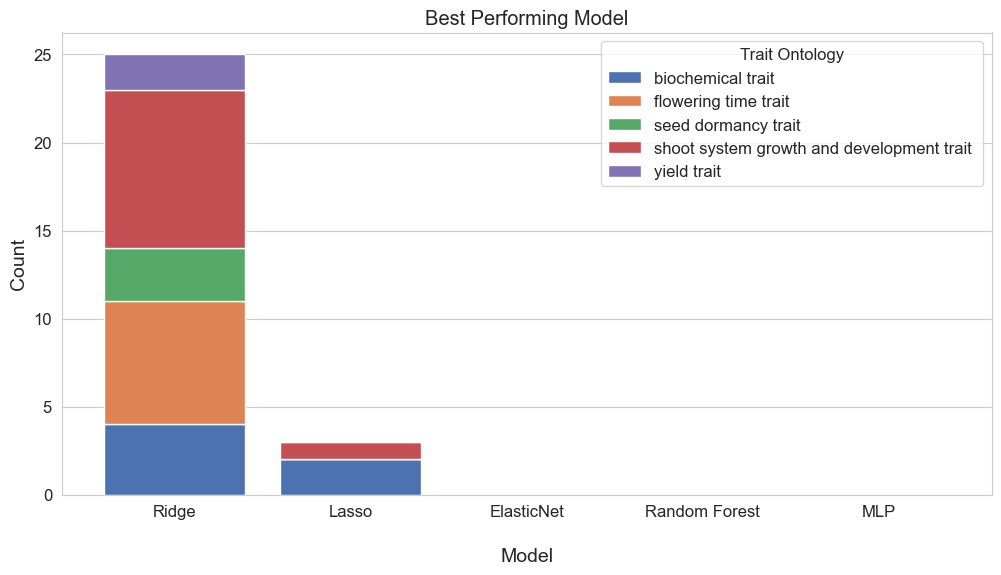

manual_ont,biochemical trait (TO:0000277),flowering time trait (TO:0002616),seed dormancy trait (TO:0000253),shoot system growth and development trait (TO:0000928),yield trait (TO:0000387)
best_model,,,,,
Ridge,4.0,7.0,3.0,9.0,2.0
Lasso,2.0,0.0,0.0,1.0,0.0
ElasticNet,0.0,0.0,0.0,0.0,0.0
Random Forest,NaN,NaN,NaN,NaN,NaN
MLP,0.0,0.0,0.0,0.0,0.0


In [37]:
import seaborn as sns

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
# Desired order for categories
desired_order = ['Ridge', 'Lasso', 'ElasticNet', 'Random Forest',  'MLP']

# Count occurrences
df_count = df_merged.groupby(['best_model', 'manual_ont']).size().unstack(fill_value=0)

# Reorder df_count according to desired_order
df_count = df_count.reindex(desired_order)

# Apply Seaborn styles and set a palette
sns.set_style("whitegrid")
sns.set_palette("deep")
df_count.loc['MLP'] = 0
df_count.loc['ElasticNet'] = 0

print(df_count.columns)
# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bottom = np.zeros(len(df_count))

for type_col in df_count.columns:
    ax.bar(df_count.index, df_count[type_col], bottom=bottom, label=type_col[:type_col.index('(')])
    bottom += df_count[type_col].values

palette = sns.color_palette("deep") # You can change "deep" to any palette of your choice


ax.set_xlabel('Model', labelpad=20, fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Best Performing Model')
ax.legend(title='Trait Ontology')

ax.xaxis.grid(False)
ax.yaxis.grid(True)
path = '/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Paper'
plt.savefig(f'{path}/trait_model_bar.svg')
plt.show()
df_count

<h3> Paper Figure 1b <h3>

Useful helper

In [30]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
def make_violin_plot(df, title=None, save_path=None, format='svg', palette=None, ax=None, tilt=0, size=4, min_max=None, fig_size= None, x_label = None, draw_connections=True):
    plt.clf()
    sns.reset_defaults()
    if fig_size:
        sns.set(rc={'figure.figsize': fig_size})
    if palette:
        sns.set_palette(palette)
    else:
        sns.set_palette(None)

    sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman', 'font.size': 12})
    sns.swarmplot(data=df, size=size, ax=ax, palette=palette)
    # remove points that are outside 1.5 * IQR
    #sns.boxplot(data=df,color="#E6E6E6", ax=ax)
    means = df.mean(axis=0)
    plt.scatter(x=range(len(means)),y=means,c="k", zorder=10, marker='_', s=2000)

    sns.violinplot(data=df, inner=None, color="#E6E6E6", ax=ax)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.xticks(rotation=tilt)
    plt.ylabel(r"$\text{r}^2$", fontsize=14)
    plt.xlabel(x_label)
    if min_max:
        plt.ylim(*min_max)


    if draw_connections:
        for idx0, idx1 in zip([i * 2 for i in range(len(df.columns)//2)],[i * 2 + 1 for i in range(len(df.columns)//2)]):
            print(idx0, idx1)
            print(plt.gca().get_children())
            locs1 = plt.gca().get_children()[idx0].get_offsets()
            locs2 = plt.gca().get_children()[idx1].get_offsets()

            # before plotting, we need to sort so that the data points
            # correspond to each other as they did in "set1" and "set2"
            sort_idxs1 = np.argsort(list(df[df.columns[idx0]]))
            sort_idxs2 = np.argsort(list(df[df.columns[idx1]]))

            # revert "ascending sort" through sort_idxs2.argsort(),
            # and then sort into order corresponding with set1
            locs2_sorted = locs2[sort_idxs2.argsort()][sort_idxs1]

            for i in range(locs1.shape[0]):
                x = [locs1[i, 0], locs2_sorted[i, 0]]
                y = [locs1[i, 1], locs2_sorted[i, 1]]
                if y[0] > y[1]:
                    plt.plot(x, y, color="red", alpha=0.1)
                else:
                    plt.plot(x, y, color="blue", alpha=0.1)

    if title:
        plt.title(title, fontsize=16)
    if save_path:
        pass
        #plt.savefig(save_path, format=format, dpi=300)
    if ax is None:
        return plt

[10, 10, 10, 10, 10, 10, 10, 10]


/tmp/ipykernel_352110/1010655131.py:18: UserWarning: 
The palette list has fewer values (6) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.swarmplot(data=df, size=size, ax=ax, palette=palette)


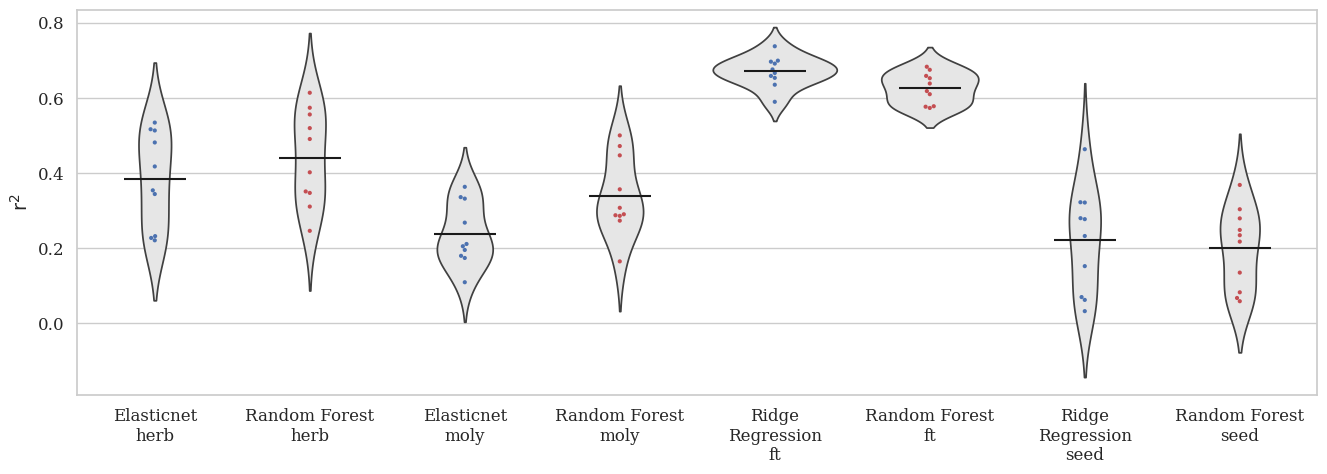

TtestResult(statistic=-4.787770488487445, pvalue=0.0009904711768866526, df=9)
TtestResult(statistic=-8.456836715342595, pvalue=1.4165507570425584e-05, df=9)
TtestResult(statistic=5.012442645585276, pvalue=0.0007265323389222366, df=9)
TtestResult(statistic=1.3447067359696785, pvalue=0.21162548810625573, df=9)


In [47]:
best_lin_herb = pd.read_csv(f'{path_to_results}/all_traits_snps/herbavore_resistance_G2P_linear_verbose.csv')
best_lin_herb = np.best_lin_herb = np.array(best_lin_herb[(best_lin_herb['Model_Name'] == 'ElasticNet') & (best_lin_herb['feature_represenation'] == 'SNPs')]['r2s'])
rf_herb = pd.read_csv(f'{path_to_results}/all_traits_snps/herbavore_resistance_G2P_rf_verbose.csv')
rf_herb = np.array(np.array(rf_herb[rf_herb['Model_Name'] == 'Random_Forest']['r2s']))

best_lin_moly = pd.read_csv(f'{path_to_results}/all_traits_snps/study_16_Mo98_linear_verbose.csv')
best_lin_moly = np.array(best_lin_moly[best_lin_moly['Model_Name'] == 'ElasticNet']['r2s'])
rf_moly = pd.read_csv(f'{path_to_results}/all_traits_snps/study_16_Mo98_rf_verbose.csv')
rf_moly = rf_moly[rf_moly['Model_Name'] == 'Random_Forest']['r2s']

best_lin_ft = pd.read_csv(f'{path_to_results}/all_traits_snps/study_12_FT10_linear_verbose.csv')
best_lin_ft = np.array(best_lin_ft[(best_lin_ft['Model_Name'] == 'Ridge') & (best_lin_ft['feature_represenation'] == 'SNPs')]['r2s'])
rf_ft = pd.read_csv(f'{path_to_results}/all_traits_snps/study_12_FT10_rf_verbose.csv')
rf_ft = rf_ft[rf_ft['Model_Name'] == 'Random_Forest']['r2s']

best_lin_seed_weight = pd.read_csv(f'{path_to_results}/all_traits_snps/study_2_YieldMainEffect2009_linear_verbose.csv')
best_lin_seed_weight = np.array(best_lin_seed_weight[(best_lin_seed_weight['Model_Name'] == 'Ridge') & (best_lin_seed_weight['feature_represenation'] == 'SNPs')]['r2s'])
rf_seed_weight = pd.read_csv(f'{path_to_results}/all_traits_snps/study_2_YieldMainEffect2009_rf_verbose.csv')
rf_seed_weight = rf_seed_weight[rf_seed_weight['Model_Name'] == 'Random_Forest']['r2s']

e= ({'Elasticnet\nherb': np.array(best_lin_herb), 'Random Forest\nherb': np.array (rf_herb),
                    'Elasticnet\nmoly':np.array(best_lin_moly),  'Random Forest\nmoly': np.array (rf_moly),
                   'Ridge\nRegression\nft': np.array(best_lin_ft), 'Random Forest\nft':  np.array (rf_ft),
                   'Ridge\nRegression\nseed': np.array(best_lin_seed_weight), 'Random Forest\nseed': np.array(rf_seed_weight)})
print([len(x) for x in e.values()])
df = pd.DataFrame({'Elasticnet\nherb': np.array(best_lin_herb), 'Random Forest\nherb': np.array (rf_herb),
                    'Elasticnet\nmoly':np.array(best_lin_moly),  'Random Forest\nmoly': np.array (rf_moly),
                   'Ridge\nRegression\nft': np.array(best_lin_ft), 'Random Forest\nft':  np.array (rf_ft),
                   'Ridge\nRegression\nseed': np.array(best_lin_seed_weight), 'Random Forest\nseed': np.array(rf_seed_weight)})

make_violin_plot(df = df[:10], size=3, fig_size=(16,5), palette=[sns.color_palette()[int(i%2==0)*3] for i in range(6)], draw_connections=False)#.savefig('genomic_prediction_programs/Experiments/TorchPractice/lassorfsummery.svg')

plt.savefig('/Research_Data_new/ReasearchProject/genomic_prediction_programs/Experiments/Paper/violin.svg')

plt.show()

# paired t test
import scipy
print(scipy.stats.ttest_rel(np.array(best_lin_herb), np.array(rf_herb)))
print(scipy.stats.ttest_rel(np.array(best_lin_moly), np.array (rf_moly)))
print(scipy.stats.ttest_rel(np.array(best_lin_ft), np.array (rf_ft)))
print(scipy.stats.ttest_rel(np.array(best_lin_seed_weight), np.array (rf_seed_weight)))

In [48]:
pc_best = pd.read_csv(f'{path_to_results}/best_model_pca_0.3_var/best_pc_model_0.3.csv').sort_values('trait')
macro, biochem = [], []

info = pd.DataFrame(info).sort_values('trait')

for markers, pc, ont in zip(pd.DataFrame(info).sort_values('trait')['r2'],pc_best.sort_values('trait')['r2_best'], df_merged['manual_ont']):

    ratio = pc/markers
    if ont == 'biochemical trait (TO:0000277)':
        biochem.append(ratio)
    else:
        macro.append(ratio)


data1 = pd.DataFrame({'ratio': [a/b for a,b in zip(pc_best['r2_best'], info['r2'])], 
                     'ont': ['biochemical trait' if e == 'biochemical trait (TO:0000277)' else 'macroscopic trait' for e in df_merged['manual_ont']]})


print(data1.groupby('ont').mean())



                      ratio
ont                        
biochemical trait  0.677957
macroscopic trait  0.903946


In [54]:
lat_long_10001 = pd.read_csv('/Research_Data_new/ReasearchProject/data/10001_genomes_lat_long.csv')

result = {'trait': [], 'r2': []}
for trait in df_merged['name']:
    phenotypes = araData.get_normalised_phenotype(trait)
    accessions = araData.get_k2029_accessions_with_phenotype(trait).astype(int)
    lat_long = lat_long_10001[np.isin(np.array(lat_long_10001['Accession ID']), accessions)][['Lat', 'Long']]
   
    lat = np.array(lat_long['Lat'])
    long = np.array(lat_long['Long'])

    lat_min, lat_max = -40, 60
    long_min, long_max = 20,70
    nans = np.argwhere(np.isnan(lat))
    lat = (np.delete(lat,nans,0))
    long = (np.delete(long,nans,0))

    x,y = np.vstack((long**2, lat**2)).T, phenotypes
    x,y = np.vstack((long, lat, np.array([lat[i] * long[i] for i in range(len(lat))]))).T, phenotypes
    x,y = np.vstack((long, lat, np.array([lat[i] * long[i] for i in range(len(lat))]), long**2, lat**2)).T, phenotypes


    y = np.delete(y,nans,0)

    in_lat = (x[:,0] > lat_min) & (x[:,0] < lat_max)
    in_long = (x[:,1] > long_min) & (x[:,1] < long_max)
    in_domain = in_lat & in_long
    x,y = x[in_domain], y[in_domain]
    if len(x) < 10:
        print(trait)
        continue
    
    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)
    result['trait'].append(trait)
    result['r2'].append(r2_score(y,y_pred))
    

data2 = pd.DataFrame({'trait': result['trait'], 'ontology': df_merged['ont_high'], 'r2': result['r2']})

print(data2[data2['ontology'] == 'macroscopic trait']['r2'].mean())
print(data2[data2['ontology'] == 'biochemical trait']['r2'].mean())

0.24922172440754126
0.14020574040245184


In [55]:

import os
import pandas as pd
import scipy

path_to_gwas = '/Research_Data_new/ReasearchProject/gwas'
print(os.listdir())

def mine_GWAS(trait):
    return pd.read_csv(f'{path_to_gwas}/{trait}/Output/Linear_Mixed_Model/{trait}/{trait}_mod_sub_{trait}_k2029.assoc.txt', sep='\t')

def get_skewness(trait, skew=False):
    return scipy.stats.kurtosis(np.log((mine_GWAS(trait)['p_wald'])))

os.chdir('/Research_Data_new/ReasearchProject')

import seaborn as sns
data3 = pd.DataFrame({'trait ontology': df_merged['ont_high'], 'skew': map(lambda x:get_skewness(x,skew=False), list(df_merged['name'])), 'best_model': list(df_merged['best_model']), 'name': list(df_merged['name'])})
#data3['best_model'].replace('Random_Forest_vanilla', 'Random Forest', inplace=True)
data3['skew'] = np.log(data3['skew'])


['.git', 'analysis.ipynb', 'Main', 'data', 'README.md']


In [57]:
data3

,trait ontology,skew,best_model,name
0,biochemical trait,3.272995,Ridge,herbavore_resistance_G2H3B
0,biochemical trait,3.483418,Ridge,herbavore_resistance_G2H4P
0,biochemical trait,5.013360,Random_Forest,herbavore_resistance_G2P
0,biochemical trait,3.236674,Ridge,herbavore_resistance_G3B
0,biochemical trait,7.545775,Lasso,herbavore_resistance_G3HP
0,biochemical trait,4.700318,Random_Forest,herbavore_resistance_G4MSB
0,biochemical trait,3.267747,Lasso,herbavore_resistance_G4P
0,biochemical trait,4.443057,Random_Forest,herbavore_resistance_G5MSP
0,macroscopic trait,2.554748,Ridge,study_12_FT10
18,biochemical trait,5.453834,Random_Forest,study_16_Cd111


In [67]:
data2

,trait,ontology,r2
0,herbavore_resistance_G2H3B,biochemical trait,0.304977
0,herbavore_resistance_G2H4P,biochemical trait,0.254159
0,herbavore_resistance_G2P,biochemical trait,0.239349
0,herbavore_resistance_G3B,biochemical trait,0.242268
0,herbavore_resistance_G3HP,biochemical trait,0.129071
0,herbavore_resistance_G4MSB,biochemical trait,0.019021
0,herbavore_resistance_G4P,biochemical trait,0.219288
0,herbavore_resistance_G5MSP,biochemical trait,0.010675
0,study_12_FT10,macroscopic trait,0.237136
18,study_16_Cd111,biochemical trait,0.044800


In [68]:
data1

,ratio,ont
0,1.058656,biochemical trait
1,1.058133,biochemical trait
2,0.886818,biochemical trait
3,0.929075,biochemical trait
4,0.594781,biochemical trait
5,0.899369,biochemical trait
6,0.916463,biochemical trait
7,0.816413,biochemical trait
8,0.973968,macroscopic trait
9,0.109241,biochemical trait


In [78]:
list(df_merged['best_model'])

['Ridge',
 'Ridge',
 'Random_Forest',
 'Ridge',
 'Lasso',
 'Random_Forest',
 'Lasso',
 'Random_Forest',
 'Ridge',
 'Random_Forest',
 'Random_Forest',
 'Ridge',
 'Ridge',
 'Ridge',
 'Ridge',
 'Ridge',
 'Random_Forest',
 'Ridge',
 'Ridge',
 'Ridge',
 'Ridge',
 'Ridge',
 'Ridge',
 'Ridge',
 'Lasso',
 'Ridge',
 'Ridge',
 'Ridge',
 'Ridge',
 'Ridge',
 'Ridge',
 'Ridge',
 'Ridge',
 'Ridge',
 'Random_Forest']

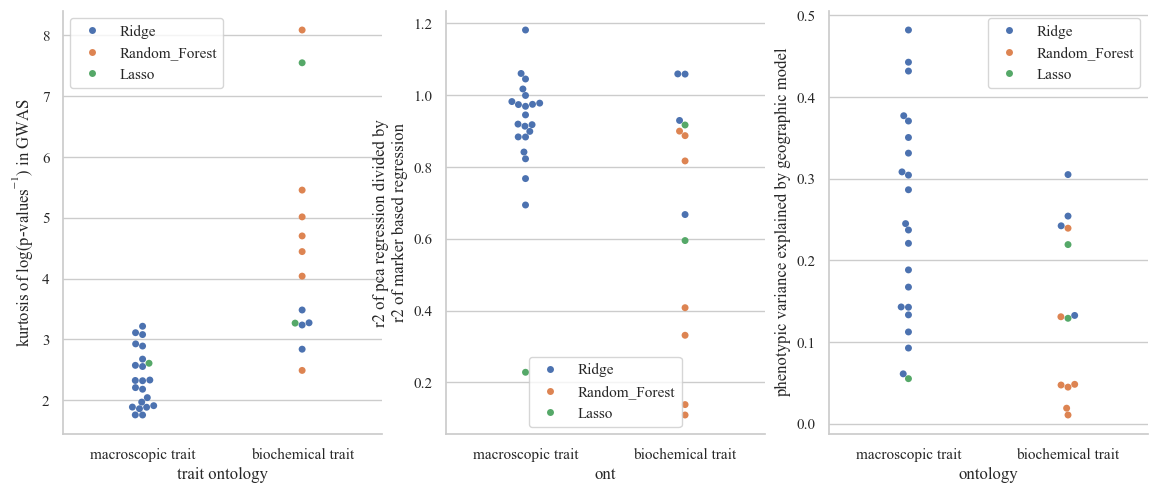

TtestResult(statistic=5.373883517292044, pvalue=6.119387915278096e-06, df=33.0)
TtestResult(statistic=2.600113183617334, pvalue=0.013834485137179242, df=33.0)
TtestResult(statistic=2.613607795668649, pvalue=0.013391546262183971, df=33.0)


In [80]:
fig, axs = plt.subplots(1,3,figsize=(14,5.5))
# set font to times new roman
plt.rcParams['font.family'] = 'Times New Roman'

# increase font si


sns.swarmplot(data = data3, x= 'trait ontology', y = 'skew', hue =list(df_merged['best_model']), ax=axs[0], order=['macroscopic trait', 'biochemical trait'],  palette='deep')
axs[0].set_ylabel('kurtosis of log(p-values$\mathregular{^{-1}}$) in GWAS')

sns.swarmplot(data1, x='ont', y='ratio', hue=list(df_merged['best_model']), ax=axs[1], palette='deep', order=['macroscopic trait', 'biochemical trait'])
axs[1].set_ylabel('r2 of pca regression divided by\nr2 of marker based regression')

sns.swarmplot(data2, x = 'ontology', y = 'r2', hue=list(df_merged['best_model']), palette='deep', ax=axs[2], order=['macroscopic trait', 'biochemical trait'])                                     
axs[2].set_ylabel('phenotypic variance explained by geographic model')




for i in range(3):
    ax.tick_params(axis='y', labelsize=7)
    for pos in ['right', 'top' ]: 
        axs[i].spines[pos].set_visible(False) 


plt.show()
print(scipy.stats.ttest_ind(data3[data3['trait ontology'] == 'biochemical trait']['skew'], data3[data3['trait ontology'] == 'macroscopic trait']['skew']))
print(scipy.stats.ttest_ind(data1[data1['ont'] == 'macroscopic trait']['ratio'], data1[data1['ont'] == 'biochemical trait']['ratio']))
print(scipy.stats.ttest_ind(data2[data2['ontology'] == 'macroscopic trait']['r2'], data2[data2['ontology'] == 'biochemical trait']['r2']))


#.savefig(f'{path_to_results}/all.svg')

In [ ]:
feature_rep = 'PCA_SNPs'
metric = 'r2s'
import pandas as pd

def get_pca_mlp(trait, model):
    df =  pd.read_csv(f'{path_to_results}/mlp_pca0.6/_{trait}_.csv')
    return (df[metric].groupby(df['variance_maintained']).mean())

def get_pca_rf(trait, model):
    df = pd.read_csv(f'{path_to_results}/pc_rf/_{trait}_rf_verbose_..csv')
    return (df[metric].groupby(df['variance_maintained']).mean())


def get_pca_regression(trait, model):
    df = pd.read_csv(f'{path_to_results}/pca_other/_{trait}_linear_verbose_.csv')
    df = df[df['Model_Name'] == model]
    return df[metric].groupby(df['variance_maintained']).mean()

def get_baseline(trait, model):
    print(trait, model)
    if model == 'rf':
        r = np.array(pd.read_csv(f'{path_to_results}/results/{trait}_rf_vanilla_500_verbose_.csv')[metric]).mean()
    if model == 'MLP':
        r = np.array(pd.read_csv(f'{path_to_results}/mlp_0.6r2/_{trait}_.csv')[metric]).mean()
    if model in ['Ridge', 'Lasso', 'ElasticNet']:
        df = pd.read_csv(f'{path_to_results}/results/{trait}_results.csv')
        r =  np.array(df[df['Model_Name'] == model]['r2_summary'])[0]
    return r    


trait = 'study_4_M130T666'

feature_representation = 'PCA_SNPs'
models = ['Ridge', 'Lasso', 'ElasticNet',  'MLP', 'rf'][::-1]

model_f = {'Ridge':get_pca_regression, 'Lasso':get_pca_regression, 'ElasticNet':get_pca_regression, 'MLP':get_pca_mlp, 'rf':get_pca_rf}

def get_datas(trait):
    datas = {}
    for model in models:
        datas[model] = model_f[model](trait, model)
    return pd.DataFrame(datas)
        

print(get_datas(trait))

study_12_FT10 rf
study_12_FT10 MLP
study_12_FT10 ElasticNet
study_12_FT10 Lasso
study_12_FT10 Ridge
herbavore_resistance_G2P rf
herbavore_resistance_G2P MLP
herbavore_resistance_G2P ElasticNet
herbavore_resistance_G2P Lasso
herbavore_resistance_G2P Ridge
study_4_M130T666 rf
study_4_M130T666 MLP
study_4_M130T666 ElasticNet
study_4_M130T666 Lasso
study_4_M130T666 Ridge


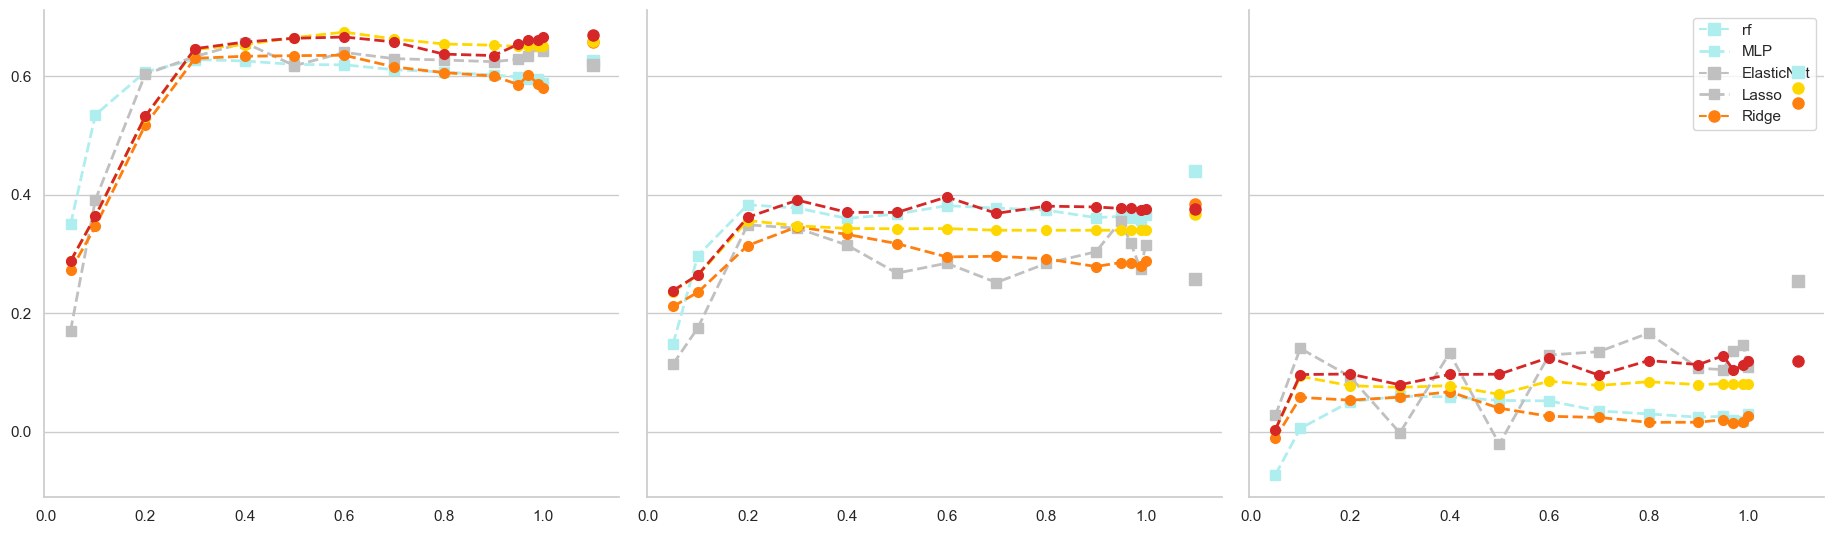

In [ ]:
colors = ['tab:red', 'gold', 'tab:orange', 'silver', 'paleturquoise'][::-1]
import seaborn as sns
sns.set_theme(style='whitegrid')
connections = []

fig, axs = plt.subplots(1,3, sharey = True, figsize=(18.5, 5.5))

for ax in axs:
    ax.grid(axis='x')
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])

    for pos in ['right', 'top' ]: 
        ax.spines[pos].set_visible(False) 


models = ['Ridge', 'Lasso', 'ElasticNet',  'MLP', 'rf'][::-1]
traits = ['study_12_FT10','herbavore_resistance_G2P', 'study_4_M130T666']
for axis, trait in zip(axs, traits):
    data = get_datas(trait)
    for i, model in enumerate(models):
        if i  < 2: marker = 's'
        else: marker = 'o'
        color = colors[i]

        base = get_baseline(trait, model)

        axis.plot(1.1, [base], color=color,linestyle='--', marker=marker,  zorder=100, markersize=8)
        axis.plot(data.index, (data[model]), color=color, linestyle='--', marker=marker, zorder=100, markersize=7, linewidth=2)


# add figure legand
plt.legend(models, loc='upper right', palette=colors)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

fig.savefig(f"{path_to_results}/pca.svg")
plt.show()